In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from statsmodels.tsa.deterministic import DeterministicProcess


In [2]:
df = pd.read_csv("Energy_data\PJME_hourly.csv", index_col = [0], parse_dates = [0])

In [3]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME energy use in MW'}, xlabel='Datetime'>

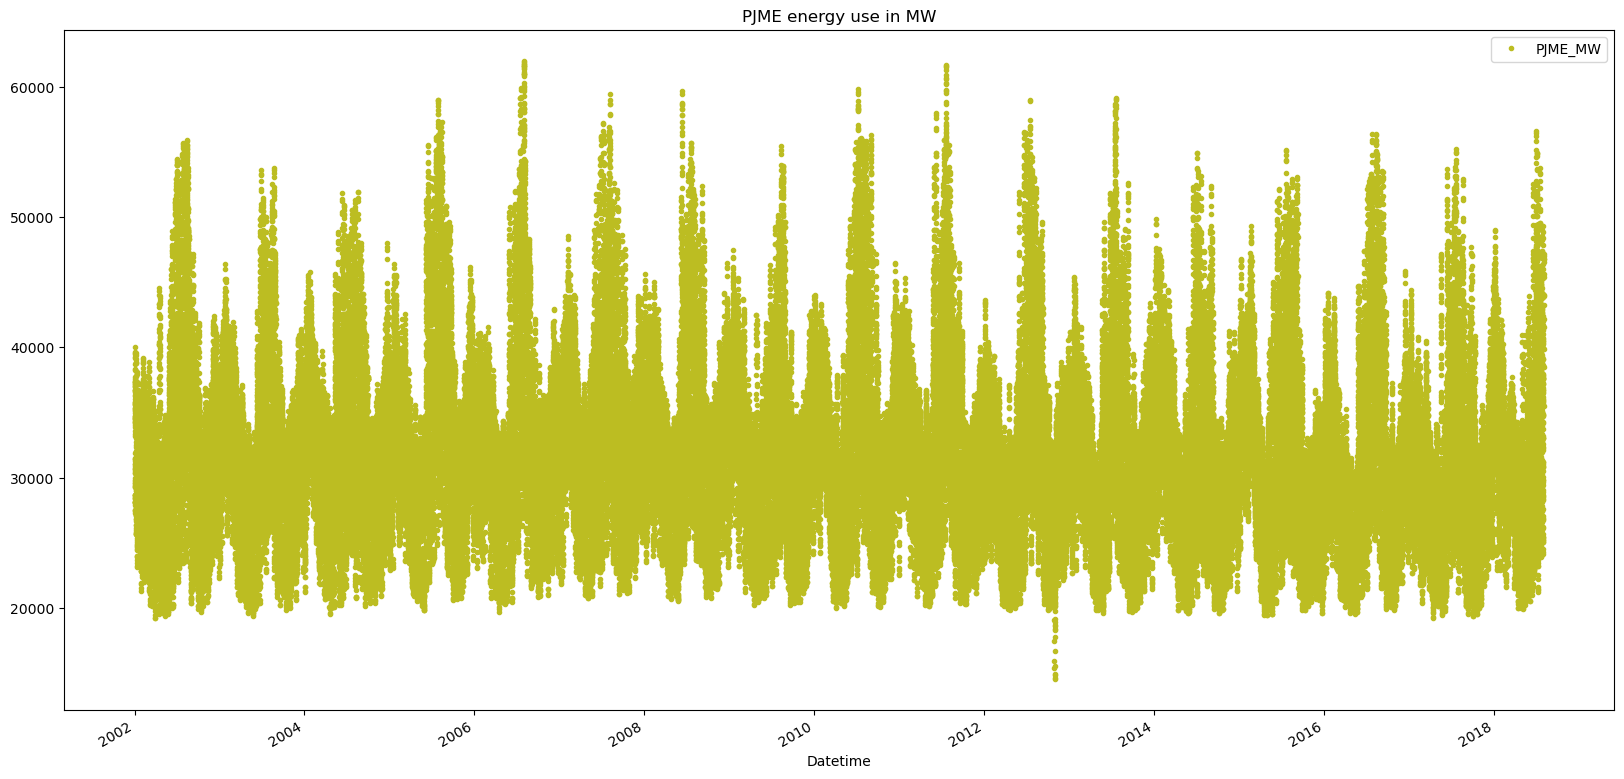

In [5]:
df.plot(style = '.', 
        figsize=(20,10), 
        color = color_pal[8],
       title = 'PJME energy use in MW'
       )

Train Test split

In [7]:
train = df.loc[df.index < '01-01-2015']
valid = df.loc[(df.index >= '01-01-2015') & (df.index < '01-01-2017')]
test = df.loc[df.index >= '01-01-2017']


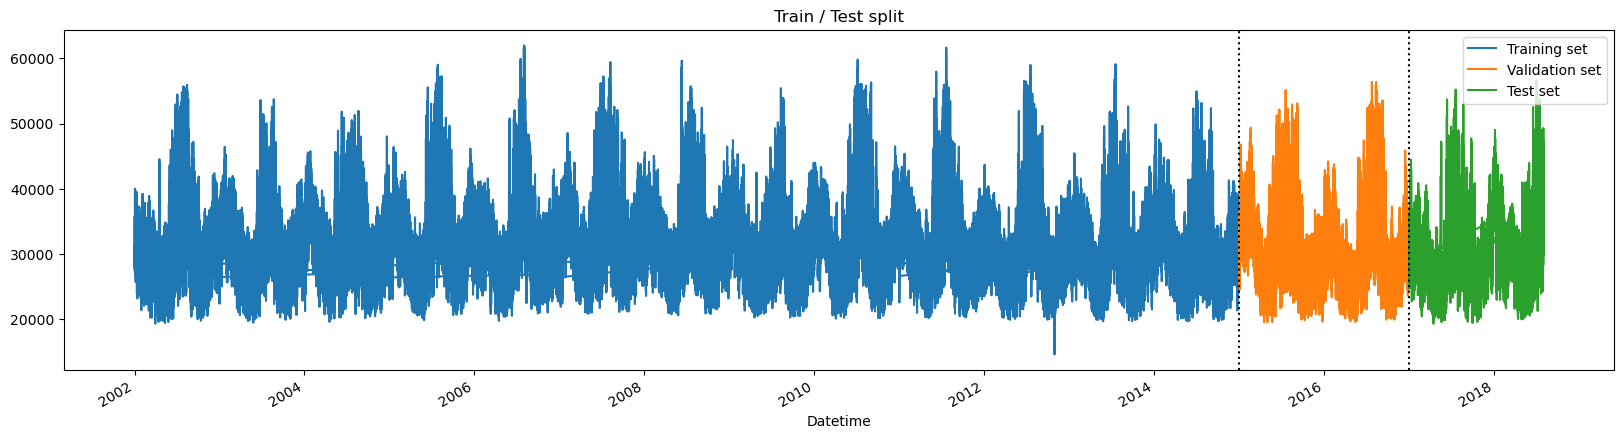

In [8]:
fig, ax = plt.subplots(figsize = (20,5))
train.plot(ax=ax, title = 'Train / Test split')
valid.plot(ax=ax)
test.plot(ax=ax)
ax.legend(['Training set', 'Validation set', 'Test set'])
ax.axvline('01-01-2015', color = 'black', ls = ':')
ax.axvline('01-01-2017', color = 'black', ls = ':')

plt.show()

<Axes: title={'center': '1 Week of data'}, xlabel='Datetime'>

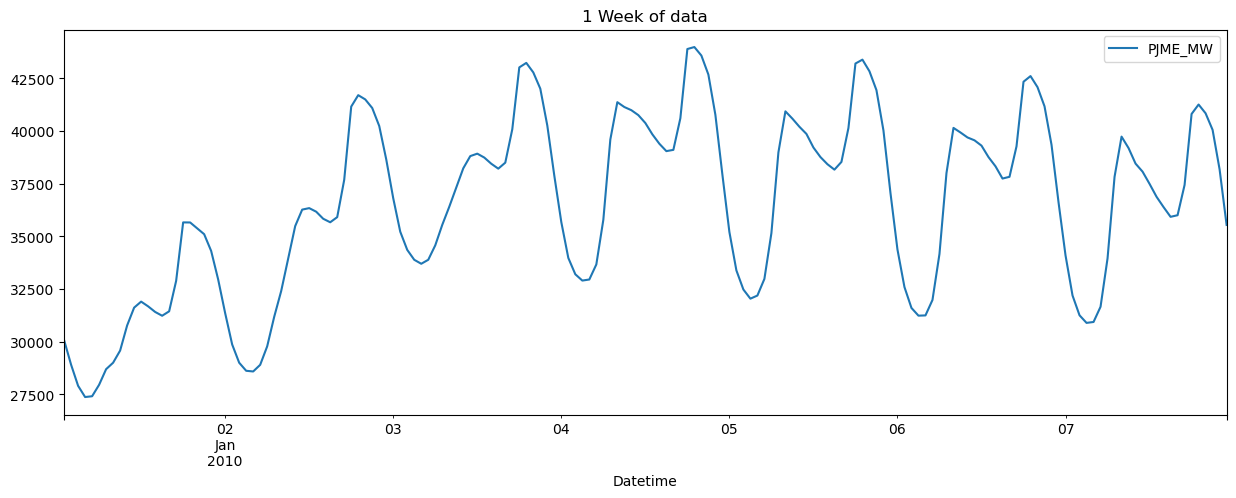

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].sort_index().plot(
     figsize=(15,5), 
       title = '1 Week of data'
)

Feature Creation

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    #df['year'] = df.index.year
    return df

In [12]:
df = create_features(df)

In [13]:
df

,PJME_MW,hour,dayofweek,quarter,month,dayofyear
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,365
2002-12-31 02:00:00,25147.0,2,1,4,12,365
2002-12-31 03:00:00,24574.0,3,1,4,12,365
2002-12-31 04:00:00,24393.0,4,1,4,12,365
2002-12-31 05:00:00,24860.0,5,1,4,12,365
...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,1


Visualize feature to target relationship

Text(0.5, 1.0, 'MW by hour')

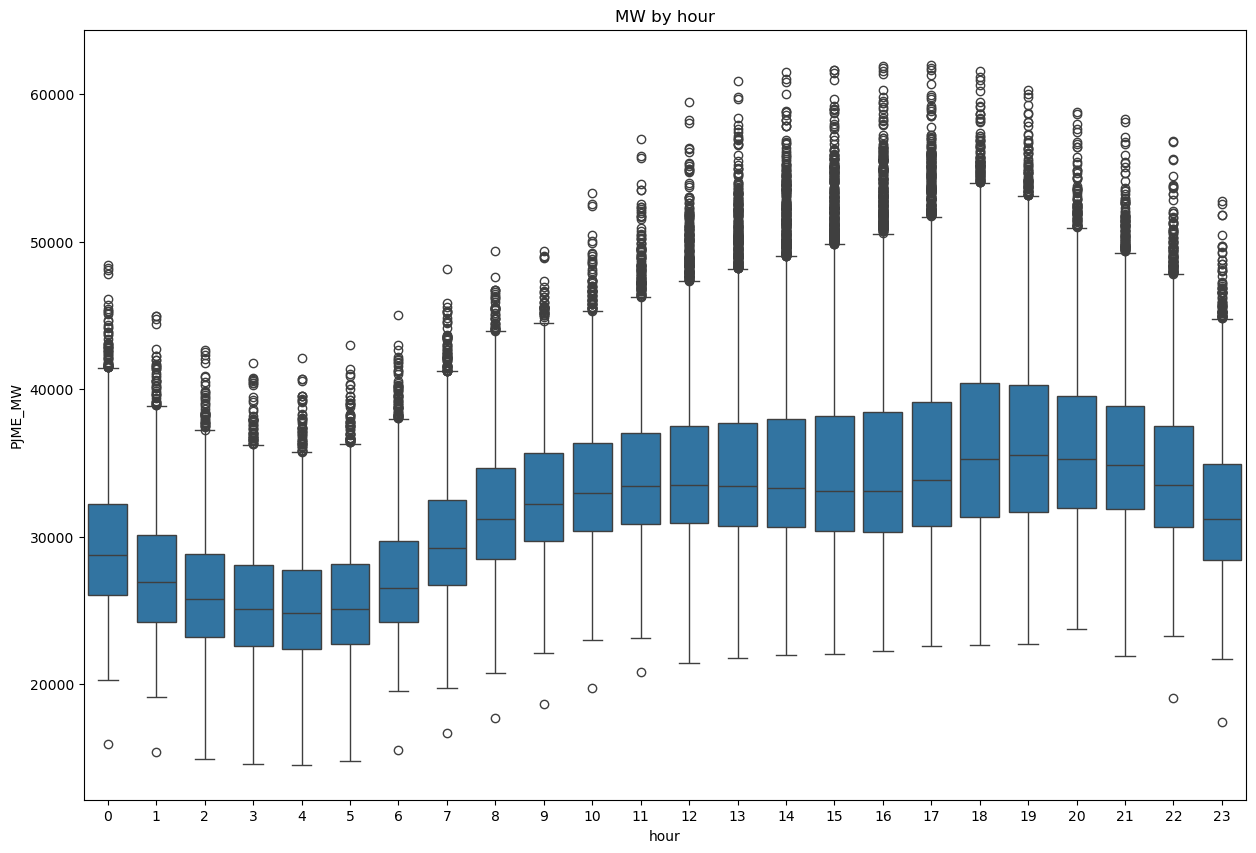

In [15]:
plt.figure(figsize = (15,10))
sns.boxplot(data=df, 
            x='hour', 
            #y = 'DAYTON_MW',
            y = 'PJME_MW'
           )
plt.title('MW by hour')

Text(0.5, 1.0, 'MW by month')

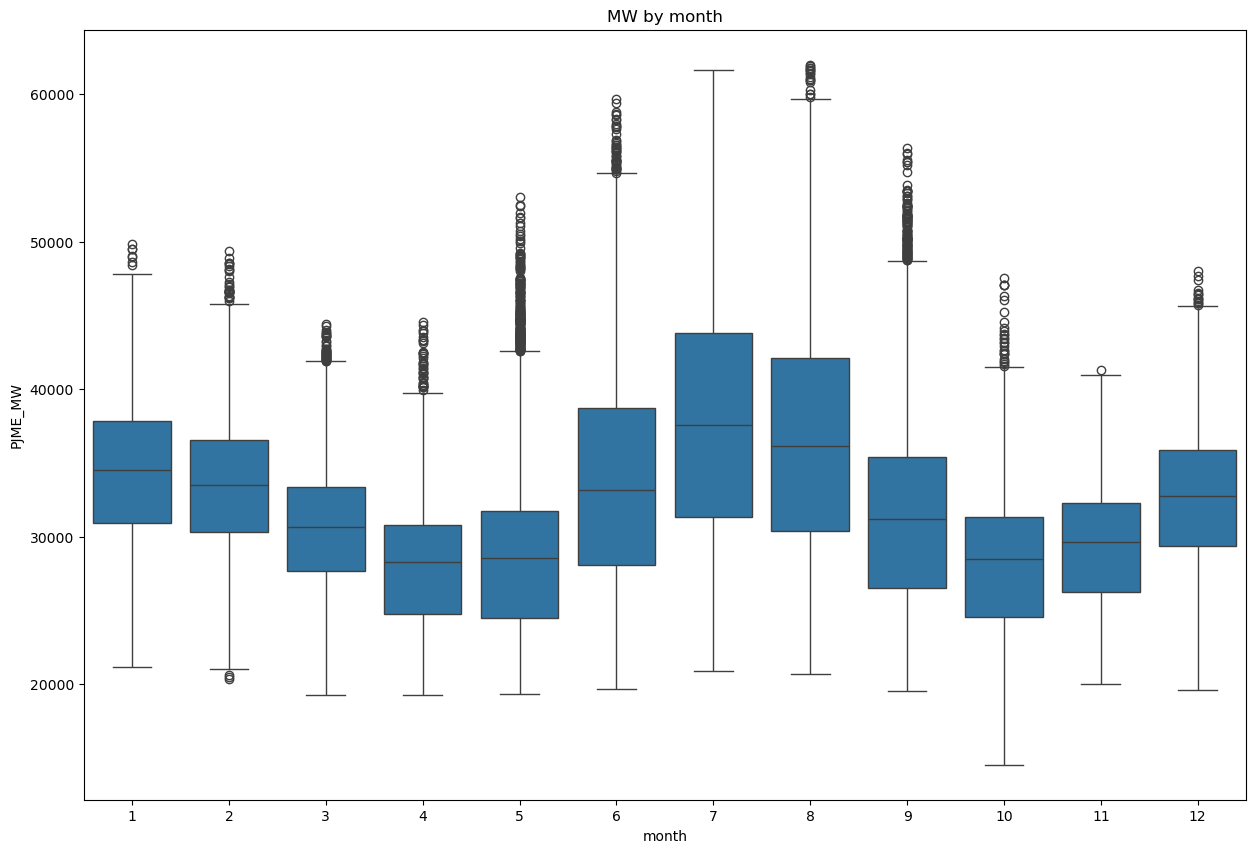

In [16]:
plt.figure(figsize = (15,10))
sns.boxplot(data=df, 
            x='month',
            y = 'PJME_MW'
           )
plt.title('MW by month')

Create model

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
model = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_rounds = 50,
                        learning_rate = 0.01

                        )

In [20]:
train = create_features(train)
valid = create_features(valid)
test = create_features(test)

In [21]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'dayofyear'], dtype='object')

In [22]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'dayofyear']
TARGET = ['PJME_MW']

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_valid = valid[FEATURES]
y_valid = valid[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_valid, y_valid)],
          verbose = 100,
         )

[0]	validation_0-rmse:6407.46713	validation_1-rmse:6689.98056
[100]	validation_0-rmse:3929.44718	validation_1-rmse:4329.59968
[200]	validation_0-rmse:3297.83957	validation_1-rmse:3774.54228
[300]	validation_0-rmse:3113.73542	validation_1-rmse:3622.91096
[400]	validation_0-rmse:3038.59816	validation_1-rmse:3575.46123
[500]	validation_0-rmse:2995.63487	validation_1-rmse:3555.98629
[600]	validation_0-rmse:2969.68488	validation_1-rmse:3553.20713
[696]	validation_0-rmse:2949.93344	validation_1-rmse:3554.29453


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


# Feature Importance

In [26]:
fi = pd.DataFrame(data = model.feature_importances_, 
             index = model.feature_names_in_,
             columns = ['importance']
            )
fi

,importance
hour,0.371995
dayofweek,0.115138
quarter,0.040424
month,0.338324
dayofyear,0.134120


<Axes: title={'center': 'Feature Importance'}>

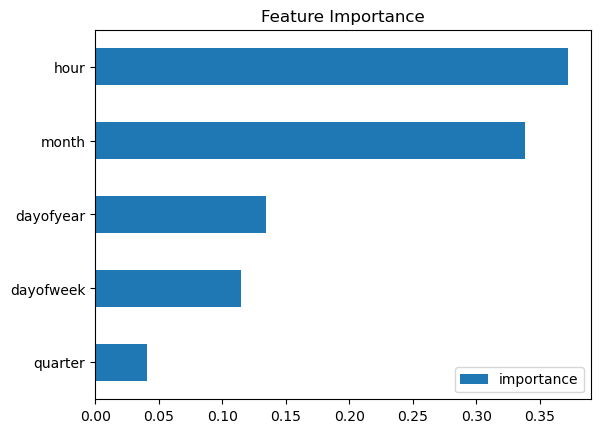

In [27]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

<Axes: xlabel='importance'>

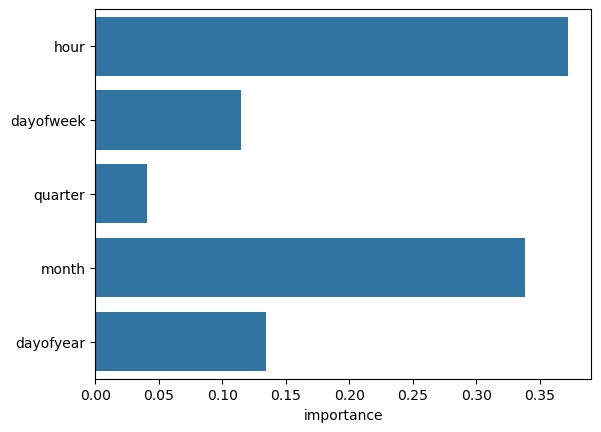

In [28]:
sns.barplot(
    fi['importance'],
    orient = 'h'
)

Forecast on Test (note: should use a validation set while training for proper good practice)

In [30]:
test['prediction'] = model.predict(X_test)

In [31]:
df = df.merge(test['prediction'], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw data and prediction')

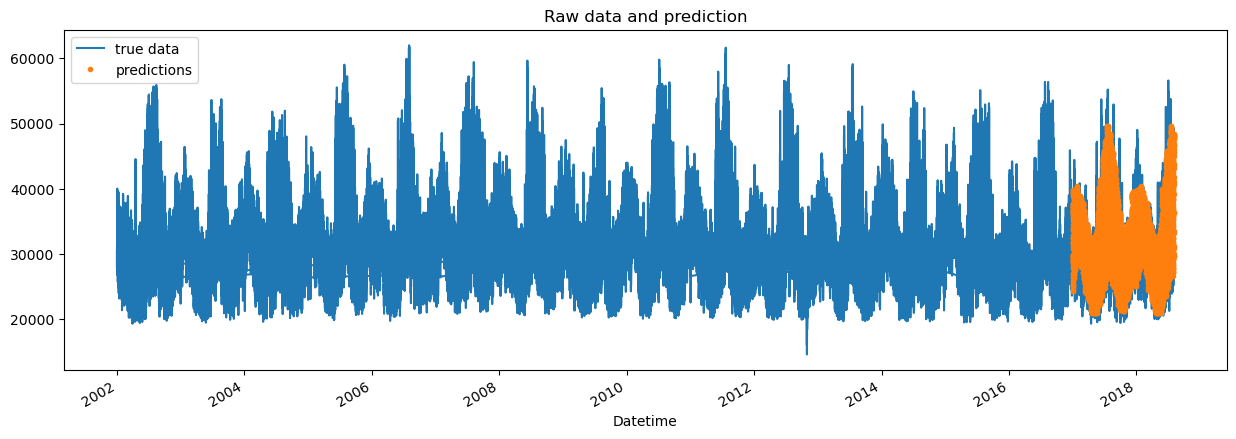

In [32]:
df['PJME_MW'].plot(figsize = (15,5))
df['prediction'].plot(style = '.')
plt.legend(['true data', 'predictions'])
plt.title("Raw data and prediction")

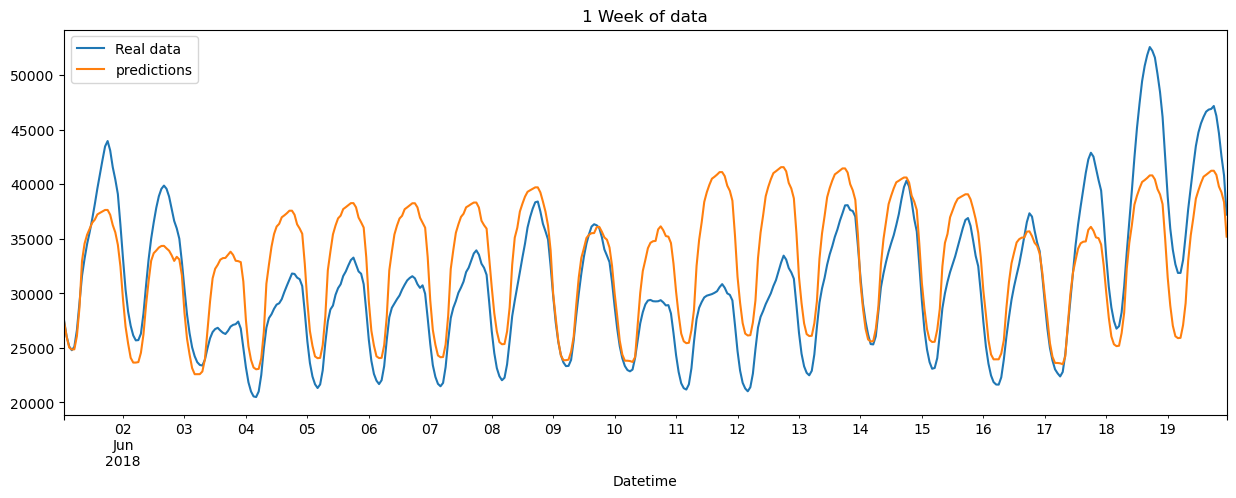

In [33]:
df.loc[(df.index > '06-01-2018') & (df.index < '06-20-2018')]['PJME_MW'].sort_index().plot(
     figsize=(15,5), 
       title = '1 Week of data'
)
df.loc[(df.index > '06-01-2018') & (df.index < '06-20-2018')]['prediction'].sort_index().plot(
     figsize=(15,5), 
       #style = '.'
)
plt.legend(['Real data', 'predictions'])

In [34]:
df[df['prediction'].isna() == False].sort_index().loc['06-20-2018']

,PJME_MW,hour,dayofweek,quarter,month,dayofyear,prediction
Datetime,,,,,,,
2018-06-20 00:00:00,33557.0,0,2,2,6,171,31515.968750
2018-06-20 01:00:00,30413.0,1,2,2,6,171,28931.003906
2018-06-20 02:00:00,28443.0,2,2,2,6,171,27082.666016
2018-06-20 03:00:00,27105.0,3,2,2,6,171,26100.699219
2018-06-20 04:00:00,26352.0,4,2,2,6,171,25926.988281
2018-06-20 05:00:00,26337.0,5,2,2,6,171,25947.976562
2018-06-20 06:00:00,27368.0,6,2,2,6,171,27095.873047
2018-06-20 07:00:00,29491.0,7,2,2,6,171,29116.083984
2018-06-20 08:00:00,31880.0,8,2,2,6,171,33000.269531


In [35]:
mse = mean_squared_error(test['PJME_MW'], test['prediction'])
mse, np.sqrt(mse)

(15630077.86638716, 3953.4893279718312)

#MSE is greater with the year feature
#proper validation
try hybrid model (take out trend first)
other video this is great now COME ONNNN

In [37]:
resid = test['PJME_MW'] - test['prediction']
#resid = resid.stack().squeeze()

In [38]:
pd.DataFrame(resid)

,0
Datetime,
2017-01-01 00:00:00,226.400391
2017-12-31 01:00:00,7380.300781
2017-12-31 02:00:00,7683.771484
2017-12-31 03:00:00,8082.001953
2017-12-31 04:00:00,8282.371094
...,...
2018-01-01 20:00:00,7844.695312
2018-01-01 21:00:00,7740.925781
2018-01-01 22:00:00,8058.718750


In [116]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y, X_val_1, X_val_2, y_val):
        self.model_1.fit(X_1,y)
    
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        y_val_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_val_1),
            index=X_val_1.index, columns=y_val.columns,
        )
    
        # YOUR CODE HERE: compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        y_val_resid = y_val - y_val_fit
        y_val_resid = y_val_resid.stack().squeeze() # wide to long

    
        # YOUR CODE HERE: fit self.model_2 on residuals
        try:
            self.model_2.fit(X_2, y_resid,
                            eval_set = [(X_2, y_resid), (X_val_2, y_val_resid)],
                            verbose = 100,
         )
        except TypeError:
            self.model_2.fit(X_2, y_resid)

    
        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long
    
        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        
         
        try:
            y_pred =  y_pred.unstack()  # long to wide
        except ValueError:
            pass
        return y_pred

In [40]:
y_train = y_train.sort_index()

In [41]:
y_train

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2014-12-31 19:00:00,38906.0
2014-12-31 20:00:00,37772.0
2014-12-31 21:00:00,36602.0


In [140]:
from sklearn.linear_model import LinearRegression

dp = DeterministicProcess(
    index=y_train.index,
    constant=True,   # intercept
    order=1,         # linear trend
    drop=True
)

X_train_trend = dp.in_sample()
X_valid_trend = dp.out_of_sample(len(X_valid))
X_valid_trend.index = y_valid.index 
'''
lr = LinearRegression(fit_intercept=False)
lr.fit(X_trend, y_train)

trend_hat = pd.Series(lr.predict(X_trend).squeeze(), index=y_train.index, name="trend_hat")
resid = (pd.Series(y_train.squeeze()) - trend_hat).rename('resid')
'''

C:\Users\auguz\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


'\nlr = LinearRegression(fit_intercept=False)\nlr.fit(X_trend, y_train)\n\ntrend_hat = pd.Series(lr.predict(X_trend).squeeze(), index=y_train.index, name="trend_hat")\nresid = (pd.Series(y_train.squeeze()) - trend_hat).rename(\'resid\')\n'

In [142]:
model = BoostedHybrid(LinearRegression(),
                      xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_rounds = 50,
                        learning_rate = 0.01
                        )
                     )

In [146]:
model.fit(X_train_trend, X_train, y_train, X_valid_trend, X_valid, y_valid)

[0]	validation_0-rmse:6408.69388	validation_1-rmse:6685.09132
[100]	validation_0-rmse:4189.92684	validation_1-rmse:6152.57873
[128]	validation_0-rmse:3971.27457	validation_1-rmse:6200.49510


In [148]:
X_test_trend = dp.out_of_sample(steps=len(y_test))
X_test_trend.index = y_test.index
#X_valid_trend.drop('const', axis = 1, inplace = True)
X_test_trend

C:\Users\auguz\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,const,trend
Datetime,,
2017-01-01 00:00:00,1.0,113927.0
2017-12-31 01:00:00,1.0,113928.0
2017-12-31 02:00:00,1.0,113929.0
2017-12-31 03:00:00,1.0,113930.0
2017-12-31 04:00:00,1.0,113931.0
...,...,...
2018-01-01 20:00:00,1.0,127818.0
2018-01-01 21:00:00,1.0,127819.0
2018-01-01 22:00:00,1.0,127820.0


In [150]:
y_pred = model.predict(X_test_trend, X_test).rename('predictions').sort_index()

In [152]:
y_pred.index = y_pred.index.get_level_values(0)

Text(0.5, 1.0, 'Raw data and prediction')

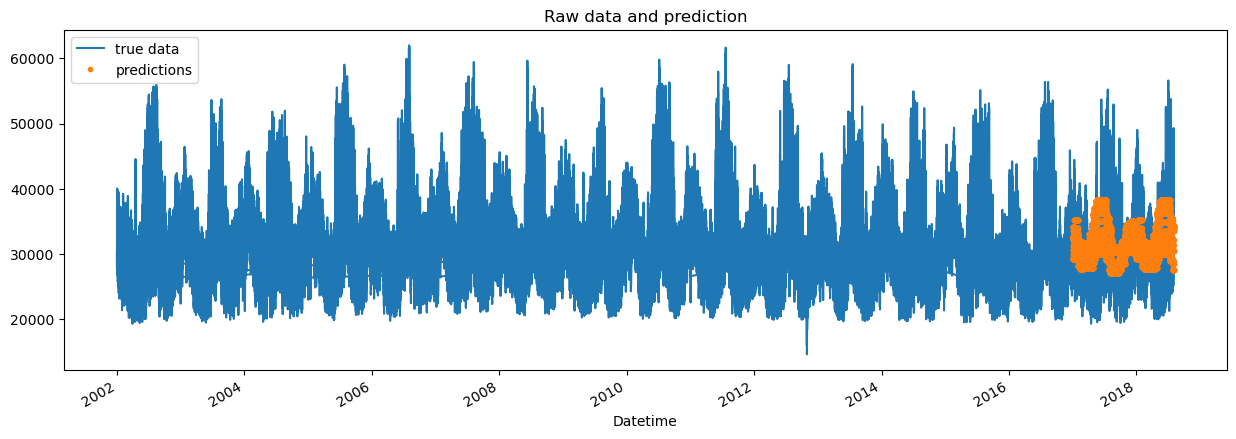

In [154]:
df['PJME_MW'].plot(figsize = (15,5))
y_pred.sort_index().plot(style = '.')
plt.legend(['true data', 'predictions'])
plt.title("Raw data and prediction")

In [156]:
test = test.merge(y_pred, how= 'left', left_index = True, right_index = True)

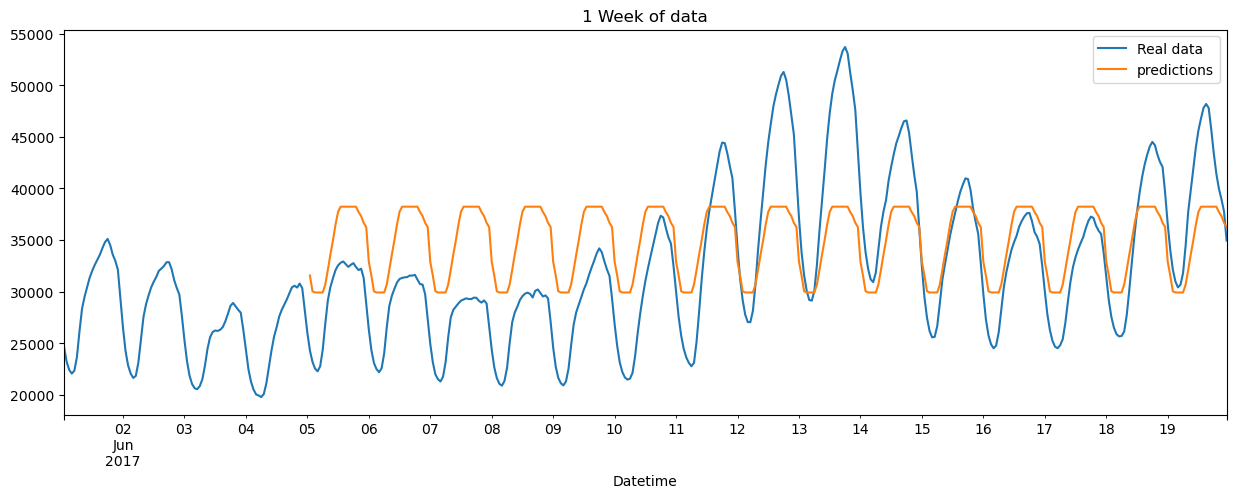

In [158]:
test.loc[(test.index > '06-01-2017') & (test.index < '06-20-2017')]['PJME_MW'].sort_index().plot(
     figsize=(15,5), 
       title = '1 Week of data'
)
test.loc[(test.index > '06-05-2017') & (test.index < '06-20-2017')]['predictions'].sort_index().plot(
     figsize=(15,5), 
       #style = '.'
)
plt.legend(['Real data', 'predictions'])

In [160]:
mse= mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)
mse, rmse
# There was no early stopping here, maybe try with it? Other models? Maybe not worth it here as there is no real trend

(27136028.04478695, 5209.22528259116)

In [ ]:
# No improvement on this dataset by adding a val